<h1><center>Rigorous EDA & Pipeline</center></h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_validate

import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

In [2]:
employee_data = pd.read_csv("../Data/regression_employee_data.csv")

In [3]:
employee_data.head()

,Emp #,Designation,Experience,Salary,AggrBehavScore,ActivityScore,LinesOfCode,Qualification,Degree,YearsOfStudy,EducationalInstitute,Gender,Empl_Band
0,e1,Director,16.0,85861,0.526928,5,1678,Grad,NaN,15.0,clg,M,A
1,e2,Jr.Dev,3.0,25376,6.420421,18,6082,Grad,Btech,16.0,clg,F,C
2,e3,Sr.Dev,6.0,38193,2.802337,7,2927,PostGrad,Msc,17.0,unv,M,B
3,e4,Jr.Dev,3.0,22807,9.374888,23,10249,NaN,Mtech,18.0,NaN,F,C
4,e5,Sr.Dev,4.0,37624,3.336564,10,3159,NaN,Btech,16.0,NaN,F,B


#### Split data into Train and Test

In [4]:
shuffleSplit = ShuffleSplit(n_splits=1, test_size=0.2, random_state=20)
for train_index, test_index in shuffleSplit.split(employee_data):
    train_set = employee_data.loc[train_index]
    test_set = employee_data.loc[test_index]

In [5]:
train_set.shape

(1209, 13)

In [6]:
test_set.shape

(303, 13)

#### Data Pre-Processing

In [7]:
YearsOfStudy_impute_value = train_set['YearsOfStudy'].mode().values[0]
Qualification_impute_value = train_set['Qualification'].mode().values[0]
Degree_impute_value = train_set['Degree'].mode().values[0]
EducationalInstitute_impute_value = train_set['EducationalInstitute'].mode().values[0]

In [8]:
def convertCategorisToCodes(columns, df):
    for column in columns:
        df[column] = pd.Categorical(df[column], categories = cat_list_dict[column])
        df[column] = df[column].cat.codes

In [9]:
cat_list_dict = {'Designation': ['Sr.Dev', 'Analyst', 'Sr.Analyst', 'Manager', 'Jr.Dev', 'Director', 'Sr.Manager'],
                'Qualification': ['Grad', 'PostGrad', 'Phd', 'postdoc'],
                'Degree': ['Btech', 'Bsc', 'Msc', 'Mba', 'IntMsc', 'B.A', 'Mtech'],
                'EducationalInstitute' : ['unv', 'iit', 'clg', 'cunv'],
                'Gender': ['M', 'F'],
                'Empl_Band': ['B', 'C', 'A']}

In [10]:
train_set.loc[train_set[train_set['LinesOfCode'] < 0].index.values, 'LinesOfCode'] = 0
train_set.drop('Emp #', axis=1, inplace=True)
train_set['YearsOfStudy'].fillna(YearsOfStudy_impute_value, inplace=True)
train_set['Qualification'].fillna(Qualification_impute_value, inplace=True)
train_set['Degree'].fillna(Degree_impute_value, inplace=True)
train_set['EducationalInstitute'].fillna(EducationalInstitute_impute_value, inplace=True)

### Hypothesis testing (ANOVA) to make Label Encoding vs One-Hot Encoding

#### Is "Designation" strongly related to "Salary" (ANOVA Test)
* **Null Hypothesis (H0):** "Designation" of the employee and "Salary" are independent
* **Alternate Hypothesis (H1):** "Designation" of the employee and "Salary" are not independent(dependent).

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

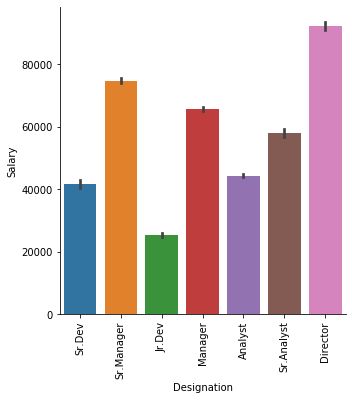

In [11]:
sns.catplot(data = train_set, x='Designation', y= 'Salary', kind='bar')
plt.xlabel("Designation")
plt.ylabel("Salary")
plt.xticks(rotation=90)

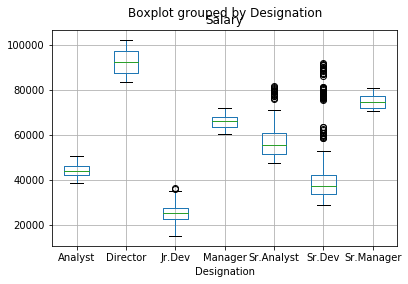

In [12]:
# to get an idea on outliers
train_set.boxplot('Salary', by='Designation')

In [13]:
mc1 = multi.MultiComparison(train_set['Salary'], train_set['Designation'])
res1 = mc1.tukeyhsd()
print(res1.summary())

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
  group1     group2     meandiff  p-adj     lower       upper    reject
-----------------------------------------------------------------------
   Analyst   Director  47968.5185  0.001  42999.6629   52937.374   True
   Analyst     Jr.Dev -18973.2553  0.001 -22581.3225 -15365.1881   True
   Analyst    Manager  21409.9124  0.001   16878.297  25941.5278   True
   Analyst Sr.Analyst  13700.6497  0.001   9916.5112  17484.7882   True
   Analyst     Sr.Dev    -2741.38 0.2045  -6132.1871    649.4271  False
   Analyst Sr.Manager   30421.774  0.001  25027.6384  35815.9096   True
  Director     Jr.Dev -66941.7737  0.001 -71203.4401 -62680.1074   True
  Director    Manager  -26558.606  0.001 -31626.0699 -21491.1422   True
  Director Sr.Analyst -34267.8687  0.001 -38679.5981 -29856.1394   True
  Director     Sr.Dev -50709.8984  0.001 -54789.2641 -46630.5328   True
  Director Sr.Manager -17546.7444  0.001 -23398.2698  -11695.219

#### As majority of the pairs giving True, we go with Lable Encding(expect "Analyst", "Sr.Dev " groups).

In [14]:
convertCategorisToCodes(['Designation'], train_set)

#train_set["Designation"] = pd.Categorical(train_set["Designation"], categories = cat_list_dict["Designation"])

#train_set = pd.get_dummies(train_set, columns=["Designation"], prefix=["Designation"], drop_first=True)
#train_set[[col for col in train_set.columns if 'Designation' in col ]].head()

#### Is "Gender" strongly related to "Salary" (ANOVA Test)
* **Null Hypothesis (H0):** "Gender" of the employee and "Salary" are independent
* **Alternate Hypothesis (H1):** "Gender" of the employee and "Salary" are not independent(dependent).

(array([0, 1]), <a list of 2 Text xticklabel objects>)

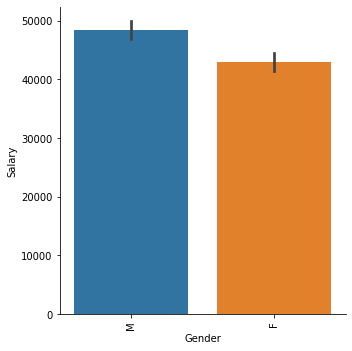

In [15]:
sns.catplot(data = train_set, x='Gender', y= 'Salary', kind='bar')
plt.xlabel("Gender")
plt.ylabel("Salary")
plt.xticks(rotation=90)

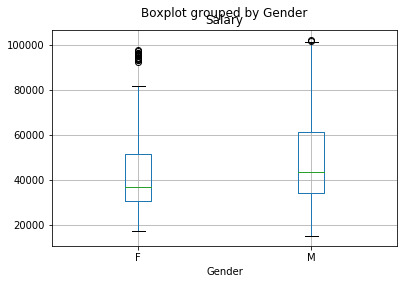

In [16]:
# to get an idea on outliers
train_set.boxplot('Salary', by='Gender')

In [17]:
ols = smf.ols(formula='Salary ~ C(Gender)', data=train_set).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     23.90
Date:                Fri, 24 Jul 2020   Prob (F-statistic):           1.15e-06
Time:                        07:49:58   Log-Likelihood:                -13640.
No. Observations:                1209   AIC:                         2.728e+04
Df Residuals:                    1207   BIC:                         2.729e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       4.297e+04    838.366     51.250      0.000    4.13e+04    4.46e+04
C(Gender)[T.M]  5452.5848   1115.414      4.888      0.000    3264.218    7640.951
==============================================================================
Omnibus:                      111.714   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.424
Skew:                           0.844   Prob(JB):                     7.17e-32
Kurtosis:                       2.983   Cond. No.                         2.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

####  P-value 0.00000115 < 0.05 hence we reject null hypothesis. Let's go with Label Encoding.

In [18]:
convertCategorisToCodes(['Gender'], train_set)

#### Is "Qualification" strongly related to "Salary" (ANOVA Test)
* **Null Hypothesis (H0):** "Qualification" of the employee and "Salary" are independent
* **Alternate Hypothesis (H1):** "Qualification" of the employee and "Salary" are not independent(dependent).

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

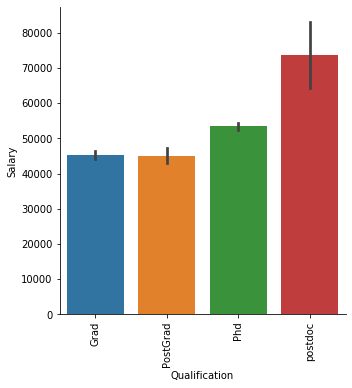

In [19]:
sns.catplot(data = train_set, x='Qualification', y= 'Salary', kind='bar')
plt.xlabel("Qualification")
plt.ylabel("Salary")
plt.xticks(rotation=90)

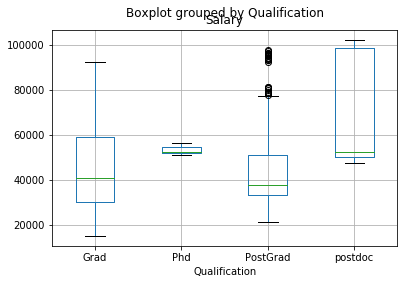

In [20]:
# to get an idea on outliers
train_set.boxplot('Salary', by='Qualification')

In [21]:
mc2 = multi.MultiComparison(train_set['Salary'], train_set['Qualification'])
res2 = mc2.tukeyhsd()
print(res2.summary())

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
 group1   group2   meandiff  p-adj     lower      upper    reject
-----------------------------------------------------------------
    Grad      Phd   7985.716 0.3696  -4712.0465 20683.4785  False
    Grad PostGrad  -316.1309    0.9  -3567.9338   2935.672  False
    Grad  postdoc 28409.0716  0.001   18880.261 37937.8821   True
     Phd PostGrad -8301.8469  0.348 -21197.5163  4593.8224  False
     Phd  postdoc 20423.3556 0.0047    4722.327 36124.3841   True
PostGrad  postdoc 28725.2025  0.001  18934.2196 38516.1854   True
-----------------------------------------------------------------


#### some pairs are strongly related and some not, os better go with One-Hot Encoding

In [22]:
train_set["Qualification"] = pd.Categorical(train_set["Qualification"], categories = cat_list_dict["Qualification"])

train_set = pd.get_dummies(train_set, columns=["Qualification"], prefix=["Qualification"], drop_first=True)
train_set[[col for col in train_set.columns if 'Qualification' in col ]].head()

,Qualification_PostGrad,Qualification_Phd,Qualification_postdoc
321,0,0,0
1254,0,0,0
71,1,0,0
1167,0,0,0
1193,0,0,0


#### Is "Degree" strongly related to "Salary" (ANOVA Test)
* **Null Hypothesis (H0):** "Degree" of the employee and "Salary" are independent
* **Alternate Hypothesis (H1):** "Degree" of the employee and "Salary" are not independent(dependent).

In [23]:
mc3 = multi.MultiComparison(train_set['Salary'], train_set['Degree'])
res3 = mc3.tukeyhsd()
print(res3.summary())

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower      upper    reject
--------------------------------------------------------------
   B.A    Bsc  -4125.6795    0.9 -26989.3186 18737.9596  False
   B.A  Btech  -4042.7998    0.9 -20002.0554 11916.4558  False
   B.A IntMsc -17075.3795 0.1099    -36039.8   1889.041  False
   B.A    Mba  -5300.0128    0.9  -28163.652 17563.6263  False
   B.A    Msc   -2536.653    0.9 -19506.7891 14433.4832  False
   B.A  Mtech  -3696.3749    0.9 -20066.9666 12674.2167  False
   Bsc  Btech     82.8797    0.9 -16518.5564 16684.3158  False
   Bsc IntMsc    -12949.7  0.443 -32457.6236  6558.2236  False
   Bsc    Mba  -1174.3333    0.9 -24490.7618 22142.0951  False
   Bsc    Msc   1589.0265    0.9 -15986.3927 19164.4457  False
   Bsc  Mtech    429.3045    0.9 -16567.9338 17426.5429  False
 Btech IntMsc -13032.5797 0.0055 -23639.6966 -2425.4628   True
 Btech    Mba   -1257.213    0.9 -17858.6491 15344.2231

#### As majority of the pairs giving False (accept null hypothesis), this is alomost like 0 - variance column. Hence removing the column.

In [24]:
train_set.drop('Degree', axis=1, inplace=True)

'''
train_set["Degree"] = pd.Categorical(train_set["Degree"], 
                                                   categories = cat_list_dict["Degree"])

train_set = pd.get_dummies(train_set, columns=["Degree"], prefix=["Degree"], drop_first=True)
train_set[[col for col in train_set.columns if 'Degree' in col ]].head()
'''

'\ntrain_set["Degree"] = pd.Categorical(train_set["Degree"], \n                                                   categories = cat_list_dict["Degree"])\n\ntrain_set = pd.get_dummies(train_set, columns=["Degree"], prefix=["Degree"], drop_first=True)\ntrain_set[[col for col in train_set.columns if \'Degree\' in col ]].head()\n'

#### Is "EducationalInstitute" strongly related to "Salary" (ANOVA Test)
* **Null Hypothesis (H0):** "EducationalInstitute" of the employee and "Salary" are independent
* **Alternate Hypothesis (H1):** "EducationalInstitute" of the employee and "Salary" are not independent(dependent).

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

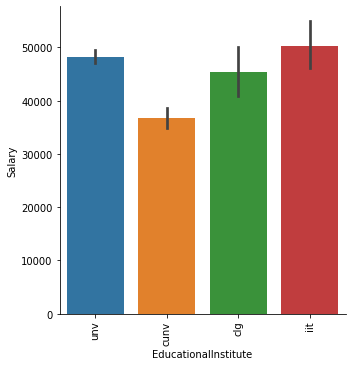

In [25]:
sns.catplot(data = train_set, x='EducationalInstitute', y= 'Salary', kind='bar')
plt.xlabel("EducationalInstitute")
plt.ylabel("Salary")
plt.xticks(rotation=90)

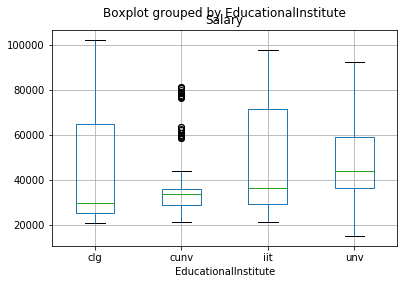

In [26]:
# to get an idea on outliers
train_set.boxplot('Salary', by='EducationalInstitute')

In [27]:
mc3 = multi.MultiComparison(train_set['Salary'], train_set['EducationalInstitute'])
res3 = mc3.tukeyhsd()
print(res3.summary())

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------
   clg   cunv -8621.0731  0.001 -14014.4674 -3227.6789   True
   clg    iit  4829.7085 0.1964  -1447.8322 11107.2493  False
   clg    unv  2801.5846 0.4007   -1805.379  7408.5482  False
  cunv    iit 13450.7817  0.001   7763.4694  19138.094   True
  cunv    unv 11422.6577  0.001   7659.3989 15185.9165   True
   iit    unv  -2028.124 0.6934   -6975.945  2919.6971  False
-------------------------------------------------------------


#### some pairs are strongly related and some not, os better go with One-Hot Encoding

In [28]:
train_set["EducationalInstitute"] = pd.Categorical(train_set["EducationalInstitute"], 
                                                   categories = cat_list_dict["EducationalInstitute"])

train_set = pd.get_dummies(train_set, columns=["EducationalInstitute"], prefix=["EducationalInstitute"], drop_first=True)
train_set[[col for col in train_set.columns if 'EducationalInstitute' in col ]].head()

,EducationalInstitute_iit,EducationalInstitute_clg,EducationalInstitute_cunv
321,0,0,0
1254,0,0,0
71,0,0,1
1167,0,0,0
1193,0,0,0


#### Is "Empl_Band" strongly related to "Salary" (ANOVA Test)
* **Null Hypothesis (H0):** "Empl_Band" of the employee and "Salary" are independent
* **Alternate Hypothesis (H1):** "Empl_Band" of the employee and "Salary" are not independent(dependent).

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

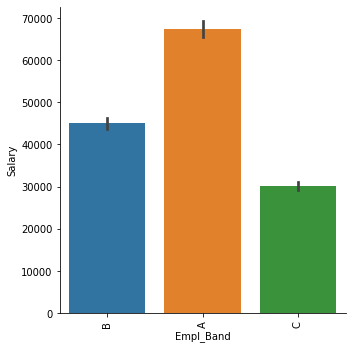

In [29]:
sns.catplot(data = train_set, x='Empl_Band', y= 'Salary', kind='bar')
plt.xlabel("Empl_Band")
plt.ylabel("Salary")
plt.xticks(rotation=90)

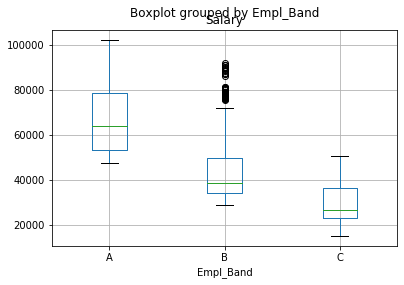

In [30]:
# to get an idea on outliers
train_set.boxplot('Salary', by='Empl_Band')

In [31]:
mc3 = multi.MultiComparison(train_set['Salary'], train_set['Empl_Band'])
res3 = mc3.tukeyhsd()
print(res3.summary())

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj    lower       upper    reject
--------------------------------------------------------------
     A      B -22443.2477 0.001   -24807.69 -20078.8053   True
     A      C -37280.9809 0.001 -39886.1416 -34675.8202   True
     B      C -14837.7332 0.001 -17060.4946 -12614.9718   True
--------------------------------------------------------------


#### As all pairs giving True (reject True - all pairs have strong differences), we go with Lable Encding

In [32]:
convertCategorisToCodes(['Empl_Band'], train_set)

In [33]:
train_set.shape

(1209, 15)

In [34]:
train_X = train_set.loc[:, [x for x in train_set.columns if x not in ['Salary']]]
train_y = train_set['Salary']

### Model Selection Process - GridSearchCV

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [36]:
poly_lr_reg_pipeline = Pipeline([
        ("poly_features", PolynomialFeatures()),
        ("lr", LinearRegression())
    ])

param_grid = {
        "poly_features__degree": [1,2,3,4]
    }

grid_search = GridSearchCV(poly_lr_reg_pipeline, param_grid, cv=10, scoring='r2')
grid_search.fit(train_X, train_y)

print("Best params : ", grid_search.best_params_)
print("Best estimator : ", grid_search.best_estimator_)

Best params :  {'poly_features__degree': 3}
Best estimator :  Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lr',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)


In [37]:
train_prediction = grid_search.best_estimator_.predict(train_X)
train_mse = mean_squared_error(train_y, train_prediction)
r2_train = r2_score(train_y, train_prediction)

print("Train R-Square score: ", r2_train)
print("Train Root Mean Squared Error : ", np.sqrt(train_mse))

Train R-Square score:  0.9845667452765103
Train Root Mean Squared Error :  2410.197696030825


#### Apply Best Model on Test Set

In [38]:
test_set.loc[test_set[test_set['LinesOfCode'] < 0].index.values, 'LinesOfCode'] = 0
test_set.drop('Emp #', axis=1, inplace=True)
test_set['YearsOfStudy'].fillna(YearsOfStudy_impute_value, inplace=True)
test_set['Qualification'].fillna(Qualification_impute_value, inplace=True)
test_set['Degree'].fillna(Degree_impute_value, inplace=True)
test_set['EducationalInstitute'].fillna(EducationalInstitute_impute_value, inplace=True)

convertCategorisToCodes(['Designation'], test_set)
#test_set["Designation"] = pd.Categorical(test_set["Designation"], categories = cat_list_dict["Designation"])
#test_set = pd.get_dummies(test_set, columns=["Designation"], prefix=["Designation"], drop_first=True)

convertCategorisToCodes(['Gender'], test_set)

test_set["Qualification"] = pd.Categorical(test_set["Qualification"], categories = cat_list_dict["Qualification"])
test_set = pd.get_dummies(test_set, columns=["Qualification"], prefix=["Qualification"], drop_first=True)

test_set.drop('Degree', axis=1, inplace=True)
'''
test_set["Degree"] = pd.Categorical(test_set["Degree"], categories = cat_list_dict["Degree"])
test_set = pd.get_dummies(test_set, columns=["Degree"], prefix=["Degree"], drop_first=True)
'''

test_set["EducationalInstitute"] = pd.Categorical(test_set["EducationalInstitute"], 
                                                  categories = cat_list_dict["EducationalInstitute"])
test_set = pd.get_dummies(test_set, columns=["EducationalInstitute"], prefix=["EducationalInstitute"], drop_first=True)
convertCategorisToCodes(['Empl_Band'], test_set)

test_X = test_set.loc[:, [x for x in test_set.columns if x not in ['Salary']]]
test_y = test_set['Salary']

In [39]:
test_prediction = grid_search.best_estimator_.predict(test_X)
test_mse = mean_squared_error(test_y, test_prediction)
r2_test = r2_score(test_y, test_prediction)

print("Test R-Square score: ", r2_test)
print("Test Root Mean Squared Error : ", np.sqrt(test_mse))

Test R-Square score:  0.9694220016766237
Test Root Mean Squared Error :  3402.0562958124297
